## PACKAGES AND LIBRARIES

In [11]:
# Load various imports
from datetime import datetime
from os import listdir
from os.path import isfile, join

import librosa
import librosa.display
from tqdm import tqdm

import numpy as np
import pandas as pd

import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint

from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.preprocessing import MinMaxScaler

In [12]:
!pip install pydub

  Obtaining dependency information for pydub from https://files.pythonhosted.org/packages/a6/53/d78dc063216e62fc55f6b2eebb447f6a4b0a59f55c8406376f76bf959b08/pydub-0.25.1-py2.py3-none-any.whl.metadata



[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [14]:
!pip install resampy


[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [15]:
!pip install librosa --upgrade


[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


# DATASET

In [17]:
mypath = "D:/DL_projects/lungs/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files"
filenames = [f for f in listdir(mypath) if (isfile(join(mypath, f)) and f.endswith('.wav'))] 

In [18]:
p_id_in_file = [] # patient IDs corresponding to each file
for name in filenames:
    p_id_in_file.append(int(name[:3]))

p_id_in_file = np.array(p_id_in_file)

In [19]:
filepaths = [join(mypath, f) for f in filenames] # full paths of files

In [20]:
p_diag = pd.read_csv("D:\DL_projects\lungs\Respiratory_Sound_Database\Respiratory_Sound_Database\patient_diagnosis.csv",header=None) # patient diagnosis file

In [21]:
p_diag

,0,1
0,101,URTI
1,102,Healthy
2,103,Asthma
3,104,COPD
4,105,URTI
...,...,...
121,222,COPD
122,223,COPD
123,224,Healthy
124,225,Healthy


In [22]:
labels = np.array([p_diag[p_diag[0] == x][1].values[0] for x in p_id_in_file]) # labels for audio files


# DATA AUGMENTATION FUNCTIONS

NOISE

In [23]:
def add_noise(data):
    noise_value = 0.015 * np.random.uniform() * np.amax(data)
    data = data + noise_value * np.random.normal(size=data.shape[0])
    return data

STRETCH

In [24]:
def stretch_process(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate=0.8)

PITCH

In [25]:
def pitch_process(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sr=sampling_rate, n_steps=pitch_factor)

# DATA PROCESS FUNCTIONS

EXTRACT FEATURES

In [27]:
def extract_process(data, sample_rate):
    output_result = np.array([])
    mean_zero = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    output_result = np.hstack((output_result, mean_zero))
    stft_out = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft_out, sr=sample_rate).T, axis=0)
    output_result = np.hstack((output_result, chroma_stft))

    mfcc_out = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate, n_mfcc=40).T, axis=0)
    output_result = np.hstack((output_result, mfcc_out))

    root_mean_out = np.mean(librosa.feature.rms(y=data).T, axis=0)
    output_result = np.hstack((output_result, root_mean_out))

    mel_spectogram = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    output_result = np.hstack((output_result, mel_spectogram))

    return output_result

EXPORT FEATURES

In [28]:
def extract_features(file_name):
    """
    This function takes in the path for an audio file as a string, loads it,
    and extracts several audio features including mean values of MFCC, Zero Crossing Rate,
    Chromagram, Root Mean Square Energy, and Mel Spectrogram from the original and its augmented versions.
    """
    try:
        audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast', duration=42, offset=0.6)

        # Extract features from the original audio data
        extracted_features = extract_process(audio, sample_rate)
        result = np.array(extracted_features)

        # Add noise and extract features
        noise_out = add_noise(audio)
        output_2 = extract_process(noise_out, sample_rate)
        result = np.vstack((result, output_2))

        # Time-stretch and then pitch-shift before extracting features
        new_out = stretch_process(audio,0.8)
        stretch_pitch = pitch_process(new_out, sample_rate,pitch_factor=0.7)
        output_3 = extract_process(stretch_pitch, sample_rate)
        result = np.vstack((result, output_3))

    except Exception as e:
        print("Error encountered while parsing file: ", file_name)
        print("Error Details:", e)
        return None

    return result

# DATA PROCESS AND ENGINEERING

TRANSFORMATION AND EXPORTATION

In [29]:

features = []

# Iterate through each sound file and extract the features
for file_name in tqdm(filepaths, desc='Extracting features'):
    data = extract_features(file_name)
    features.append(data)

print('Finished feature extraction from ', len(features), ' files')
features = np.array(features)
                    
                    
                    
                    
                    


Extracting features:   0%|          | 3/920 [00:13<52:14,  3.42s/it]  d:\DL_projects\lungs\env\Lib\site-packages\librosa\core\pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
Extracting features:  22%|██▏       | 199/920 [03:09<10:55,  1.10it/s]d:\DL_projects\lungs\env\Lib\site-packages\librosa\core\pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
Extracting features: 100%|██████████| 920/920 [29:54<00:00,  1.95s/it]   

Finished feature extraction from  920  files


In [30]:
# delete the very rare diseases
new_features = np.delete(features, np.where((labels == 'Asthma') | (labels == 'LRTI'))[0], axis=0)

new_labels = np.delete(labels, np.where((labels == 'Asthma') | (labels == 'LRTI'))[0], axis=0)

In [31]:
# print class counts
unique_elements, counts_elements = np.unique(new_labels, return_counts=True)
print(np.asarray((unique_elements, counts_elements)))

[['Bronchiectasis' 'Bronchiolitis' 'COPD' 'Healthy' 'Pneumonia' 'URTI']
 ['16' '13' '793' '35' '37' '23']]


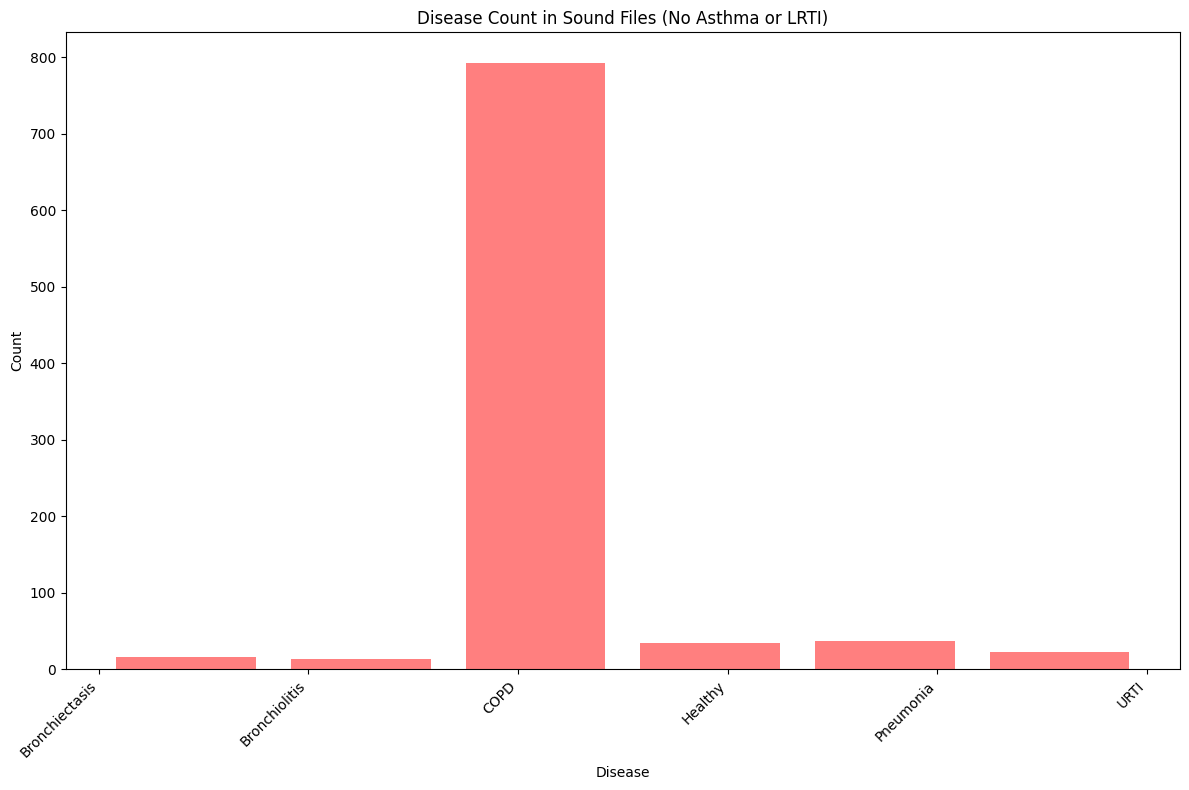

In [32]:
plt.figure(figsize=(12, 8))
plt.hist(unique_elements, bins=len(unique_elements), weights=counts_elements, align='mid', rwidth=0.8, alpha=0.5, color='red')

plt.ylabel('Count')
plt.xlabel('Disease')
plt.title('Disease Count in Sound Files (No Asthma or LRTI)')
plt.xticks(rotation=45, ha='right')  # Rotating the x-axis labels for better visibility
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

Flattened features array for preapering 1D CNN Model

In [33]:
flattened_features = new_features.reshape(-1, 182)


In [34]:
augmented_labels = np.repeat(labels, 3)

In [35]:
augmented_features = np.reshape(features, (-1, 182))  # Flatten the feature sets

mask = ~np.isin(augmented_labels, ['Asthma', 'LRTI'])
augmented_features = augmented_features[mask]
augmented_labels = augmented_labels[mask]

In [36]:
unique_values = set(augmented_labels)
unique_values

{'Bronchiectasis', 'Bronchiolitis', 'COPD', 'Healthy', 'Pneumonia', 'URTI'}

In [37]:
le = LabelEncoder()
i_labels = le.fit_transform(augmented_labels)
oh_labels = to_categorical(i_labels)

In [38]:
oh_labels

array([[0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.],
       ...,
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0.]])

In [39]:
original_labels = le.inverse_transform(i_labels)
original_labels

array(['URTI', 'URTI', 'URTI', ..., 'Pneumonia', 'Pneumonia', 'Pneumonia'],
      dtype='<U14')

In [40]:
flattened_features.shape

(2751, 182)

In [41]:
# train test split
x_train, x_test, y_train, y_test = train_test_split(flattened_features, oh_labels, stratify=oh_labels,
                                                    test_size=0.2, random_state = 42)

In [42]:
#SCALER & TRANSFORMATION
scaler_data = StandardScaler()

In [43]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(2200, 182)
(2200, 6)
(551, 182)
(551, 6)


In [44]:
x_train = scaler_data.fit_transform(x_train)
x_test = scaler_data.transform(x_test)

In [45]:
x_train = np.expand_dims(x_train,axis=2)
x_test = np.expand_dims(x_test,axis=2)

# 1D CNN Model

In [46]:
from tensorflow.keras import layers, Sequential

num_labels = len(np.unique(new_labels))  # Determine the number of unique classes

Model = Sequential([
    layers.Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)),
    layers.MaxPooling1D(pool_size=5, strides = 2, padding = 'same'),
    layers.Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'),
    layers.MaxPooling1D(pool_size=5, strides = 2, padding = 'same'),
    layers.Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'),
    layers.MaxPooling1D(pool_size=5, strides = 2, padding = 'same'),
    layers.Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'),
    layers.MaxPooling1D(pool_size=5, strides = 2, padding = 'same'),
    layers.Conv1D(32, kernel_size=5, strides=1, padding='same', activation='relu'),
    layers.MaxPooling1D(pool_size=5, strides = 2, padding = 'same'),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(units=32, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(units=num_labels, activation='softmax')
])

d:\DL_projects\lungs\env\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [47]:
Model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])


In [48]:
early_stop = tensorflow.keras.callbacks.EarlyStopping(monitor="loss",patience=3,mode="min")

In [49]:
evConv1D_Model = Model.fit(x_train, y_train, batch_size=64, epochs=50, validation_data=(x_test, y_test), callbacks=[early_stop])

Epoch 1/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 6s 104ms/step - accuracy: 0.5902 - loss: 1.2409 - val_accuracy: 0.8639 - val_loss: 0.6303
Epoch 2/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 91ms/step - accuracy: 0.8718 - loss: 0.6487 - val_accuracy: 0.8639 - val_loss: 0.6010
Epoch 3/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 92ms/step - accuracy: 0.8525 - loss: 0.6652 - val_accuracy: 0.8639 - val_loss: 0.5080
Epoch 4/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 91ms/step - accuracy: 0.8800 - loss: 0.4913 - val_accuracy: 0.8639 - val_loss: 0.5608
Epoch 5/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 91ms/step - accuracy: 0.8488 - loss: 0.5694 - val_accuracy: 0.8639 - val_loss: 0.4628
Epoch 6/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - accuracy: 0.8749 - loss: 0.4453 - val_accuracy: 0.8675 - val_loss: 0.3996
Epoch 7/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 91ms/step - accuracy: 0.8844 - loss: 0.4163 - val_accuracy: 0.8657 - val_loss: 0.3990
Epoch 8/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 91ms/step - accuracy: 0.8731 - loss: 0.4089 - val_accuracy: 0.8657 - 

In [50]:
Model_Results = Model.evaluate(x_test,y_test)
print("LOSS:  " + "%.4f" % Model_Results[0])
print("ACCURACY:  " + "%.4f" % Model_Results[1])

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9166 - loss: 0.2562
LOSS:  0.2441
ACCURACY:  0.9256


Plotting Train and Validation Loss & Accuracy:

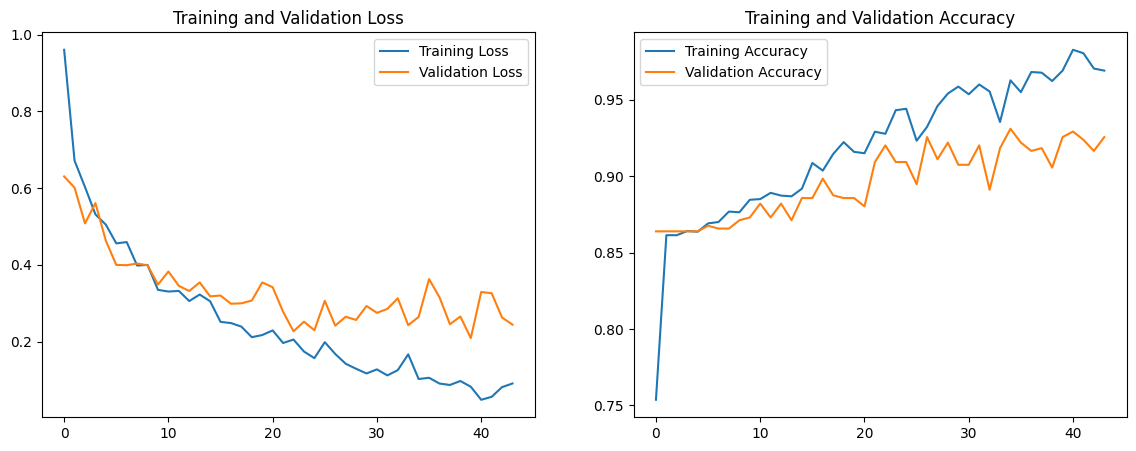

In [51]:
# Plotting loss
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(evConv1D_Model.history['loss'], label='Training Loss')
plt.plot(evConv1D_Model.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss')

# Plotting accuracy
plt.subplot(1, 2, 2)
plt.plot(evConv1D_Model.history['accuracy'], label='Training Accuracy')
plt.plot(evConv1D_Model.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.show()


Confusion Matrix:

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step


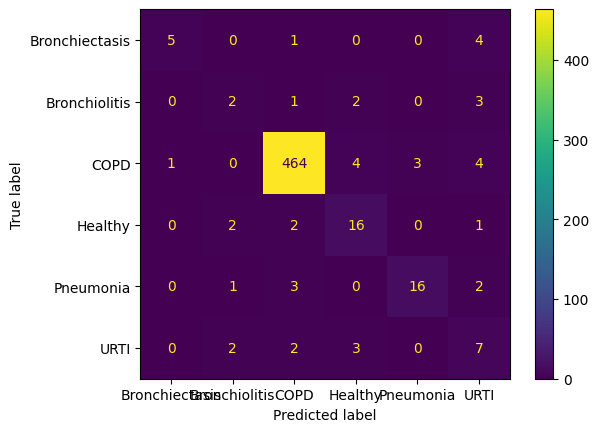

In [52]:
# Getting the predictions
y_pred = Model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

confusion_mtx = confusion_matrix(y_true, y_pred_classes)

cm_display = ConfusionMatrixDisplay(confusion_mtx, display_labels=le.classes_).plot()

In [53]:
from sklearn.metrics import accuracy_score
def predict(x_test):
    y_pred = Model.predict(x_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = np.argmax(y_test, axis=1)
    mapping = {
        0: 'Bronchiectasis',
        1: 'Bronchiolitis',
        2: 'COPD',
        3: 'Healthy',
        4: 'Pneumonia',
        5: 'URTI'
    }

    # Replace numerical labels with original labels
    predictions = [mapping[label] for label in y_pred_classes]
    accuracy = accuracy_score(y_true, y_pred_classes)
    print("Test Accuracy:", accuracy)
    
    return predictions



In [54]:
predict(x_test)

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Test Accuracy: 0.925589836660617


['COPD',
 'COPD',
 'Pneumonia',
 'COPD',
 'COPD',
 'COPD',
 'COPD',
 'Bronchiectasis',
 'COPD',
 'COPD',
 'COPD',
 'COPD',
 'COPD',
 'COPD',
 'COPD',
 'COPD',
 'COPD',
 'COPD',
 'COPD',
 'COPD',
 'COPD',
 'URTI',
 'COPD',
 'Pneumonia',
 'COPD',
 'COPD',
 'COPD',
 'COPD',
 'COPD',
 'COPD',
 'COPD',
 'COPD',
 'URTI',
 'COPD',
 'COPD',
 'COPD',
 'Healthy',
 'Pneumonia',
 'COPD',
 'COPD',
 'COPD',
 'COPD',
 'COPD',
 'COPD',
 'COPD',
 'Pneumonia',
 'Healthy',
 'COPD',
 'COPD',
 'COPD',
 'URTI',
 'COPD',
 'Healthy',
 'COPD',
 'Healthy',
 'COPD',
 'COPD',
 'COPD',
 'COPD',
 'COPD',
 'COPD',
 'COPD',
 'COPD',
 'Bronchiolitis',
 'COPD',
 'COPD',
 'COPD',
 'COPD',
 'COPD',
 'COPD',
 'COPD',
 'COPD',
 'COPD',
 'COPD',
 'Pneumonia',
 'COPD',
 'COPD',
 'COPD',
 'COPD',
 'COPD',
 'COPD',
 'COPD',
 'COPD',
 'URTI',
 'COPD',
 'Pneumonia',
 'COPD',
 'COPD',
 'COPD',
 'COPD',
 'Healthy',
 'COPD',
 'COPD',
 'COPD',
 'COPD',
 'COPD',
 'COPD',
 'COPD',
 'COPD',
 'COPD',
 'COPD',
 'COPD',
 'COPD',
 'COPD',


In [56]:
from tensorflow.keras.models import save_model
import os

model_path = "D:/DL_projects/lungs"
if not os.path.exists(model_path):
    os.makedirs(model_path)

Model.save(os.path.join(model_path, "Diagnosis.h5"))

print("Model saved successfully. You can download it from the following link:")
print(os.path.join(model_path, "Diagnosised.h5"))


Model saved successfully. You can download it from the following link:
D:/DL_projects/lungs\Diagnosised.h5
